Instead of the book exercises, we are going to deal with our own dataset from Withings. We are going to (try and) predict my weight using RNNs!

In [18]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from pathlib import Path


In [19]:
csv_path = Path(os.path.expanduser("~/Downloads/withings_data/weight.csv"))
csv_path

PosixPath('/Users/nikolaoschachampis/Downloads/withings_data/weight.csv')

In [65]:
weight_df = pd.read_csv(csv_path, index_col="Date", parse_dates=True)
weight_df

,Weight (kg),Fat mass (kg),Bone mass (kg),Muscle mass (kg),Hydration (kg),Comments
Date,,,,,,
2024-05-16 09:14:29,75.55,15.80,2.98,56.76,41.65,NaN
2024-05-14 08:52:56,75.72,16.03,2.98,56.70,41.61,NaN
2024-04-26 08:31:35,75.88,15.33,3.01,57.52,42.28,NaN
2024-04-23 08:23:13,74.25,15.15,2.95,56.13,41.13,NaN
2024-04-19 08:10:33,74.32,15.27,2.95,56.09,41.10,NaN
...,...,...,...,...,...,...
2016-11-20 20:42:35,84.50,NaN,NaN,NaN,NaN,NaN
2016-10-18 20:11:12,83.00,NaN,NaN,NaN,NaN,NaN
2016-10-10 21:19:21,82.00,NaN,NaN,NaN,NaN,NaN


We have 469 data points ranging from 2016 to 2024.

In [66]:
weight_df.index

DatetimeIndex(['2024-05-16 09:14:29', '2024-05-14 08:52:56',
               '2024-04-26 08:31:35', '2024-04-23 08:23:13',
               '2024-04-19 08:10:33', '2024-04-16 08:12:17',
               '2024-04-12 08:14:38', '2024-04-09 08:55:31',
               '2024-04-05 08:55:50', '2024-04-02 09:01:46',
               ...
               '2017-06-20 20:41:54', '2017-06-20 20:35:20',
               '2017-06-03 10:03:46', '2017-05-06 22:15:44',
               '2016-12-16 20:47:04', '2016-11-20 20:42:35',
               '2016-10-18 20:11:12', '2016-10-10 21:19:21',
               '2016-10-03 08:00:22', '2016-09-27 20:05:27'],
              dtype='datetime64[ns]', name='Date', length=469, freq=None)

In [67]:
weight_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 469 entries, 2024-05-16 09:14:29 to 2016-09-27 20:05:27
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Weight (kg)       469 non-null    float64
 1   Fat mass (kg)     393 non-null    float64
 2   Bone mass (kg)    393 non-null    float64
 3   Muscle mass (kg)  393 non-null    float64
 4   Hydration (kg)    393 non-null    float64
 5   Comments          1 non-null      object 
dtypes: float64(5), object(1)
memory usage: 25.6+ KB


For simplicity, let's keep only the `Weight (kg)` column (resulting to a `Series` object):

In [68]:
weight_df = weight_df["Weight (kg)"]
weight_df

Date
2024-05-16 09:14:29    75.55
2024-05-14 08:52:56    75.72
2024-04-26 08:31:35    75.88
2024-04-23 08:23:13    74.25
2024-04-19 08:10:33    74.32
                       ...  
2016-11-20 20:42:35    84.50
2016-10-18 20:11:12    83.00
2016-10-10 21:19:21    82.00
2016-10-03 08:00:22    83.00
2016-09-27 20:05:27    84.00
Name: Weight (kg), Length: 469, dtype: float64

<Axes: xlabel='Date'>

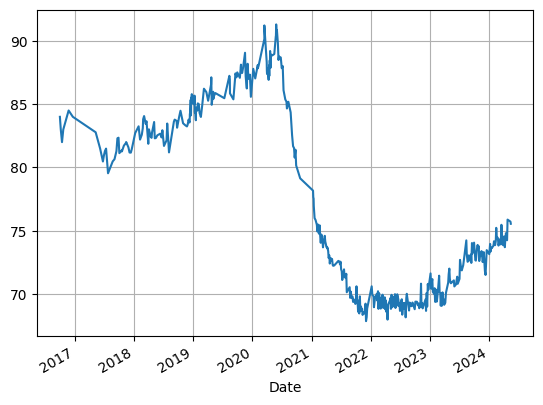

In [69]:
weight_df.plot(grid=True)

Let's resample the dataframe to have monthly data points:

In [71]:
df_monthly = weight_df.resample('ME').mean()
df_monthly

Date
2016-09-30    84.000000
2016-10-31    82.666667
2016-11-30    84.500000
2016-12-31    84.000000
2017-01-31          NaN
                ...    
2024-01-31    73.596667
2024-02-29    74.367143
2024-03-31    74.214286
2024-04-30    74.507500
2024-05-31    75.635000
Freq: ME, Name: Weight (kg), Length: 93, dtype: float64

In [72]:
df_monthly.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 93 entries, 2016-09-30 to 2024-05-31
Freq: ME
Series name: Weight (kg)
Non-Null Count  Dtype  
--------------  -----  
86 non-null     float64
dtypes: float64(1)
memory usage: 1.5 KB


We have NaN values. Let's fill them out:

In [73]:
df_monthly = df_monthly.interpolate()
df_monthly

Date
2016-09-30    84.000000
2016-10-31    82.666667
2016-11-30    84.500000
2016-12-31    84.000000
2017-01-31    83.756000
                ...    
2024-01-31    73.596667
2024-02-29    74.367143
2024-03-31    74.214286
2024-04-30    74.507500
2024-05-31    75.635000
Freq: ME, Name: Weight (kg), Length: 93, dtype: float64

In [76]:
df_monthly.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 93 entries, 2016-09-30 to 2024-05-31
Freq: ME
Series name: Weight (kg)
Non-Null Count  Dtype  
--------------  -----  
93 non-null     float64
dtypes: float64(1)
memory usage: 3.5 KB


<Axes: xlabel='Date'>

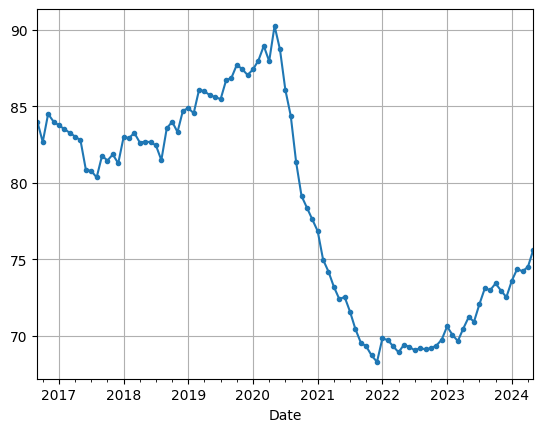

In [77]:
df_monthly.plot(grid=True, marker=".")

There are definetely trends here, but there doesn't appear to be any significant seasonality.

Ideally, we should remove trends and seasonality using differencing, but let's skip that for now.

Also, we should run an ARMA and a linear model first to have them as baselines.

In [88]:
from statsmodels.tsa.arima.model import ARIMA

origin, today = "2016-09-30", "2019-05-31"
weight_series = df_monthly.loc[origin:today].asfreq("ME")
model = ARIMA(weight_series,
              order=(1, 1, 1))  # also applies 1 round of differencing
model = model.fit()
y_pred = model.forecast()
y_pred

2019-06-30    85.802021
Freq: ME, dtype: float64

In [83]:
df_monthly["2019-06-30"]  # target value

85.5975

The SARIMA model prediction looks good enough for one month. Let's try to compute the MAE on a series of predictions:

In [89]:
# "today" loops from 2019-03-01 up to 2022-05-31
# every loop, we train from origin to "today" and forecast the next month
origin, start_date, end_date = "2016-09-30", "2019-03-01", "2022-05-31"
time_period = pd.date_range(start_date, end_date, freq="ME")
weight_series = df_monthly.loc[origin:end_date].asfreq("ME")
y_preds = []
for today in time_period.shift(-1):
    model = ARIMA(weight_series[origin:today],  # train on data up to "today"
                  order=(1, 1, 1))
    model = model.fit()  # note that we retrain the model every day!
    y_pred = model.forecast().iloc[0]
    y_preds.append(y_pred)

y_preds = pd.Series(y_preds, index=time_period)
mae = (y_preds - weight_series[time_period]).abs().mean()

/Users/nikolaoschachampis/Library/Caches/pypoetry/virtualenvs/handson-ml3-DRIwlIAE-py3.10/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/nikolaoschachampis/Library/Caches/pypoetry/virtualenvs/handson-ml3-DRIwlIAE-py3.10/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/nikolaoschachampis/Library/Caches/pypoetry/virtualenvs/handson-ml3-DRIwlIAE-py3.10/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/nikolaoschac

In [90]:
mae

0.7912105697520178

I think it will be hard to beat that! Also in the figure below, the predictions overlap almost perfectly with the targets so they are not visible:

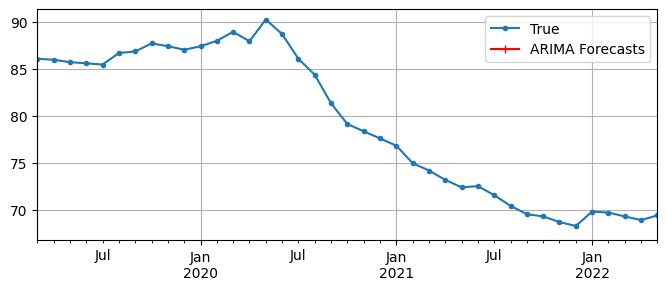

In [99]:
# displays the ARIMA forecasts
fig, ax = plt.subplots(figsize=(8, 3))
weight_series.loc[time_period].plot(label="True", ax=ax, marker=".", grid=True)
ax.plot(y_preds, color="r", marker="+", label="ARIMA Forecasts")
plt.legend()
plt.show()

Now let's try a linear model. First, let's split the data to train, validation and test periods and divide by 100 so the values are near the 0-1 range:

In [101]:
weight_train = df_monthly["2016-09-30": "2021-12-31"] / 100
weight_valid = df_monthly["2022-01-31": "2023-03-31"] / 100
weight_test = df_monthly["2023-04-30":] / 100

And now let's create the datasets:

In [143]:
seq_length = 3
train_ds = tf.keras.utils.timeseries_dataset_from_array(
    weight_train.to_numpy(),
    targets=weight_train[seq_length:],
    sequence_length=seq_length,
    batch_size=4,
    shuffle=True,
    seed=42
)
valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    weight_valid.to_numpy(),
    targets=weight_valid[seq_length:],
    sequence_length=seq_length,
    batch_size=4
)
test_ds = tf.keras.utils.timeseries_dataset_from_array(
    weight_test.to_numpy(),
    targets=weight_test[seq_length:],
    sequence_length=seq_length,
    batch_size=4
)

In [144]:
for item in train_ds.take(1):
    print(item)

(<tf.Tensor: shape=(4, 3), dtype=float64, numpy=
array([[0.85975 , 0.85725 , 0.855975],
       [0.8686  , 0.87712 , 0.87424 ],
       [0.83512 , 0.83268 , 0.83024 ],
       [0.86085 , 0.85975 , 0.85725 ]])>, <tf.Tensor: shape=(4,), dtype=float64, numpy=array([0.8547  , 0.87042 , 0.8278  , 0.855975])>)


So, one training "example" is a sequence of three consecutive monthly weights (e.g. 0.8741, 0.8799, 0.88944), with a corresponding target (next month's weight) of 0.879455.

Let's try the linear model:

In [145]:
tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_shape=[seq_length])
])
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_mae", patience=50, restore_best_weights=True)
opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
history = model.fit(train_ds, validation_data=valid_ds, epochs=500,
                    callbacks=[early_stopping_cb])

Epoch 1/500


2024-05-19 14:07:29.866420: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node SGD/AssignVariableOp.


16/16 [==============================] - 0s 14ms/step - loss: 0.0126 - mae: 0.1394 - val_loss: 0.0047 - val_mae: 0.0964
Epoch 2/500
16/16 [==============================] - 0s 6ms/step - loss: 0.0015 - mae: 0.0502 - val_loss: 1.2240e-04 - val_mae: 0.0147
Epoch 3/500
16/16 [==============================] - 0s 6ms/step - loss: 3.6577e-04 - mae: 0.0228 - val_loss: 2.3993e-05 - val_mae: 0.0059
Epoch 4/500
16/16 [==============================] - 0s 6ms/step - loss: 1.7230e-04 - mae: 0.0141 - val_loss: 3.2568e-04 - val_mae: 0.0250
Epoch 5/500
16/16 [==============================] - 0s 6ms/step - loss: 1.1261e-04 - mae: 0.0118 - val_loss: 9.5273e-05 - val_mae: 0.0127
Epoch 6/500
16/16 [==============================] - 0s 6ms/step - loss: 1.0234e-04 - mae: 0.0101 - val_loss: 1.7868e-04 - val_mae: 0.0181
Epoch 7/500
16/16 [==============================] - 0s 7ms/step - loss: 9.8033e-05 - mae: 0.0098 - val_loss: 1.3021e-04 - val_mae: 0.0152
Epoch 8/500
16/16 [==============================]

In order to compare the mae with the ARIMA model, we have to multiply it by 100 since we used scaled data to train the linear model:

In [146]:
valid_loss, valid_mae = model.evaluate(valid_ds)
print(valid_mae * 100)

3/3 [==============================] - 0s 5ms/step - loss: 2.3993e-05 - mae: 0.0059
0.5945245269685984


The Mean Absolute Error of the linear model is 0.4Kg, better than the ARIMA model :)

Let's try a SimpleRNN:

In [147]:
def fit_and_evaluate(model, train_set, valid_set, learning_rate, epochs=500):
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor="val_mae", patience=50, restore_best_weights=True)
    opt = tf.keras.optimizers.legacy.SGD(learning_rate=learning_rate, momentum=0.9)
    model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
    history = model.fit(train_set, validation_data=valid_set, epochs=epochs,
                        callbacks=[early_stopping_cb])
    valid_loss, valid_mae = model.evaluate(valid_set)
    return valid_mae * 100

In [148]:
tf.keras.backend.clear_session()
simple_rnn_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(1, input_shape=[None, 1])
])
print(fit_and_evaluate(model, train_ds, valid_ds, learning_rate=0.02))

Epoch 1/500
16/16 [==============================] - 0s 14ms/step - loss: 1.5203e-04 - mae: 0.0118 - val_loss: 1.9330e-04 - val_mae: 0.0189
Epoch 2/500
16/16 [==============================] - 0s 6ms/step - loss: 1.0467e-04 - mae: 0.0103 - val_loss: 1.1396e-04 - val_mae: 0.0141
Epoch 3/500
16/16 [==============================] - 0s 6ms/step - loss: 1.0298e-04 - mae: 0.0104 - val_loss: 1.4147e-04 - val_mae: 0.0160
Epoch 4/500
16/16 [==============================] - 0s 6ms/step - loss: 1.0080e-04 - mae: 0.0101 - val_loss: 2.1030e-04 - val_mae: 0.0198
Epoch 5/500
16/16 [==============================] - 0s 6ms/step - loss: 1.2000e-04 - mae: 0.0124 - val_loss: 1.0124e-04 - val_mae: 0.0132
Epoch 6/500
16/16 [==============================] - 0s 6ms/step - loss: 1.0624e-04 - mae: 0.0104 - val_loss: 1.7815e-04 - val_mae: 0.0181
Epoch 7/500
16/16 [==============================] - 0s 6ms/step - loss: 1.0980e-04 - mae: 0.0105 - val_loss: 1.3529e-04 - val_mae: 0.0156
Epoch 8/500
16/16 [=======

It performs similar to the linear model.

Let's try a bigger model:

In [114]:
tf.keras.backend.clear_session()
with tf.device("/cpu:0"):
    univar_model = tf.keras.Sequential([
        tf.keras.layers.SimpleRNN(8, input_shape=[None, 1]),
        tf.keras.layers.Dense(1)  # no activation function by default
    ])
    print(fit_and_evaluate(univar_model, train_ds, valid_ds, learning_rate=0.05))

Epoch 1/500
16/16 [==============================] - 0s 7ms/step - loss: 0.0960 - mae: 0.3645 - val_loss: 0.0560 - val_mae: 0.3345
Epoch 2/500
16/16 [==============================] - 0s 2ms/step - loss: 0.0143 - mae: 0.1441 - val_loss: 0.0162 - val_mae: 0.1797
Epoch 3/500
16/16 [==============================] - 0s 2ms/step - loss: 0.0027 - mae: 0.0621 - val_loss: 0.0079 - val_mae: 0.1253
Epoch 4/500
16/16 [==============================] - 0s 2ms/step - loss: 0.0016 - mae: 0.0474 - val_loss: 0.0067 - val_mae: 0.1160
Epoch 5/500
16/16 [==============================] - 0s 2ms/step - loss: 0.0011 - mae: 0.0372 - val_loss: 0.0048 - val_mae: 0.0974
Epoch 6/500
16/16 [==============================] - 0s 2ms/step - loss: 8.2045e-04 - mae: 0.0302 - val_loss: 0.0014 - val_mae: 0.0534
Epoch 7/500
16/16 [==============================] - 0s 2ms/step - loss: 7.4838e-04 - mae: 0.0301 - val_loss: 0.0025 - val_mae: 0.0704
Epoch 8/500
16/16 [==============================] - 0s 2ms/step - loss: 7.

Even better!

The MAE is just fine already, but let's also use a Deep RNN just for fun:

In [149]:
with tf.device("/cpu:0"):
    deep_model = tf.keras.Sequential([
        tf.keras.layers.SimpleRNN(8, return_sequences=True, input_shape=[None, 1]),
        tf.keras.layers.SimpleRNN(8, return_sequences=True),
        tf.keras.layers.SimpleRNN(8),
        tf.keras.layers.Dense(1)
    ])
    print(fit_and_evaluate(deep_model, train_ds, valid_ds, learning_rate=0.01))

Epoch 1/500
16/16 [==============================] - 1s 12ms/step - loss: 0.0401 - mae: 0.2470 - val_loss: 0.0108 - val_mae: 0.1470
Epoch 2/500
16/16 [==============================] - 0s 3ms/step - loss: 0.0074 - mae: 0.1013 - val_loss: 2.9367e-04 - val_mae: 0.0238
Epoch 3/500
16/16 [==============================] - 0s 3ms/step - loss: 9.5268e-04 - mae: 0.0346 - val_loss: 0.0015 - val_mae: 0.0543
Epoch 4/500
16/16 [==============================] - 0s 3ms/step - loss: 9.8677e-04 - mae: 0.0359 - val_loss: 0.0015 - val_mae: 0.0545
Epoch 5/500
16/16 [==============================] - 0s 3ms/step - loss: 0.0010 - mae: 0.0376 - val_loss: 0.0015 - val_mae: 0.0544
Epoch 6/500
16/16 [==============================] - 0s 3ms/step - loss: 7.3545e-04 - mae: 0.0313 - val_loss: 0.0022 - val_mae: 0.0658
Epoch 7/500
16/16 [==============================] - 0s 2ms/step - loss: 7.1124e-04 - mae: 0.0299 - val_loss: 0.0015 - val_mae: 0.0551
Epoch 8/500
16/16 [==============================] - 0s 2ms/st

It doesn't add much, in fact it performed worse.

But how can I predict my next month's weight?

In [150]:
# RNNS take 3D inputs of shape (batch_size, time_steps, features)
X = weight_test.to_numpy()[np.newaxis, -seq_length:, np.newaxis]
X

array([[[0.74214286],
        [0.745075  ],
        [0.75635   ]]])

In [151]:
# predict my weight for June 2024 based on the last 3 months weights
univar_model.predict(X)

1/1 [==============================] - 0s 55ms/step


array([[0.7320942]], dtype=float32)

73.2?? I find that hard to believe I'm afraid, I'm on an upward trend.. but a man can hope!

What about the deep model?


In [152]:
deep_model.predict(X)

1/1 [==============================] - 0s 160ms/step


array([[0.7555474]], dtype=float32)

That one seems more reasonable.


Let's predict the next 3 months by concatenating the predictions to the inputs:

In [153]:
X = weight_test.to_numpy()[np.newaxis, -seq_length:, np.newaxis]
for step_ahead in range(3):
    y_pred_one = univar_model.predict(X)
    X = np.concatenate([X, y_pred_one.reshape(1, 1, 1)], axis=1)

1/1 [==============================] - 0s 15ms/step


In [154]:
X[:, -3:,:]

array([[[0.73209423],
        [0.36999536],
        [0.58903873]]])

Hmm, the predictions look awful this way...


In [156]:
X = weight_test.to_numpy()[np.newaxis, -seq_length:, np.newaxis]
for step_ahead in range(3):
    y_pred_one = deep_model.predict(X)
    X = np.concatenate([X, y_pred_one.reshape(1, 1, 1)], axis=1)

X[:, -3:,:]

1/1 [==============================] - 0s 23ms/step


array([[[0.7555474 ],
        [0.37289545],
        [0.88959074]]])


What if we train an RNN to predict the next 3 values in one shot?

In [157]:
def split_inputs_and_targets(univar_series, ahead=3):
    return univar_series[:, :-ahead], univar_series[:, -ahead:]

In [206]:
# Use 6 months of data to predict the next 3 months
new_seq_length = 6
ahead_train_ds = tf.keras.utils.timeseries_dataset_from_array(
    weight_train.to_numpy(),
    targets=None,
    sequence_length=new_seq_length + 3,
    batch_size=4,
    shuffle=True,
    seed=42
)
ahead_valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    weight_valid.to_numpy(),
    targets=None,
    sequence_length=new_seq_length + 3,
    batch_size=4
)
ahead_test_ds = tf.keras.utils.timeseries_dataset_from_array(
    weight_test.to_numpy(),
    targets=None,
    sequence_length=new_seq_length + 3,
    batch_size=4
)

In [207]:
for item in ahead_train_ds.take(1):
    print(item)

tf.Tensor(
[[0.81453333 0.81853333 0.8127     0.82985    0.829275   0.83255
  0.826325   0.8269     0.8266    ]
 [0.8035     0.817675   0.81453333 0.81853333 0.8127     0.82985
  0.829275   0.83255    0.826325  ]
 [0.83512    0.83268    0.83024    0.8278     0.8085     0.80776667
  0.8035     0.817675   0.81453333]
 [0.83993333 0.83316667 0.84710556 0.84878235 0.845475   0.86085
  0.85975    0.85725    0.855975  ]], shape=(4, 9), dtype=float64)


In [208]:
ahead_train_ds = ahead_train_ds.map(split_inputs_and_targets)
ahead_valid_ds = ahead_valid_ds.map(split_inputs_and_targets)
ahead_test_ds = ahead_test_ds.map(split_inputs_and_targets)

In [209]:
for item in ahead_train_ds.take(1):
    print(item)

(<tf.Tensor: shape=(4, 6), dtype=float64, numpy=
array([[0.83512   , 0.83268   , 0.83024   , 0.8278    , 0.8085    ,
        0.80776667],
       [0.855975  , 0.8547    , 0.8669    , 0.8686    , 0.87712   ,
        0.87424   ],
       [0.82985   , 0.829275  , 0.83255   , 0.826325  , 0.8269    ,
        0.8266    ],
       [0.81346667, 0.7914    , 0.78373333, 0.77606667, 0.7684    ,
        0.7497625 ]])>, <tf.Tensor: shape=(4, 3), dtype=float64, numpy=
array([[0.8035    , 0.817675  , 0.81453333],
       [0.87042   , 0.8741    , 0.8799    ],
       [0.8244    , 0.8148    , 0.835525  ],
       [0.7419625 , 0.73203   , 0.72408333]])>)


In [210]:
tf.keras.backend.clear_session()
with tf.device("/cpu:0"):
    ahead_model = tf.keras.Sequential([
        tf.keras.layers.SimpleRNN(8, input_shape=[None, 1]),
        tf.keras.layers.Dense(3)
    ])
    print(fit_and_evaluate(ahead_model, ahead_train_ds, ahead_valid_ds,
                 learning_rate=0.02))

Epoch 1/500
14/14 [==============================] - 0s 9ms/step - loss: 0.2483 - mae: 0.5606 - val_loss: 0.0315 - val_mae: 0.2496
Epoch 2/500
14/14 [==============================] - 0s 2ms/step - loss: 0.0180 - mae: 0.1673 - val_loss: 0.0096 - val_mae: 0.1374
Epoch 3/500
14/14 [==============================] - 0s 2ms/step - loss: 0.0041 - mae: 0.0775 - val_loss: 0.0019 - val_mae: 0.0608
Epoch 4/500
14/14 [==============================] - 0s 2ms/step - loss: 0.0021 - mae: 0.0503 - val_loss: 0.0104 - val_mae: 0.1431
Epoch 5/500
14/14 [==============================] - 0s 2ms/step - loss: 0.0014 - mae: 0.0405 - val_loss: 0.0045 - val_mae: 0.0944
Epoch 6/500
14/14 [==============================] - 0s 2ms/step - loss: 0.0015 - mae: 0.0471 - val_loss: 0.0059 - val_mae: 0.1087
Epoch 7/500
14/14 [==============================] - 0s 2ms/step - loss: 0.0014 - mae: 0.0401 - val_loss: 0.0070 - val_mae: 0.1184
Epoch 8/500
14/14 [==============================] - 0s 2ms/step - loss: 0.0014 - m

In [211]:
test_loss, test_mae = ahead_model.evaluate(ahead_test_ds)
test_mae * 100

2/2 [==============================] - 0s 40ms/step - loss: 2.8626e-04 - mae: 0.0214


2.1444737911224365

In [212]:
X = weight_test.to_numpy()[np.newaxis, -new_seq_length:]  # shape [1, 6, 1]
Y_pred = ahead_model.predict(X)  # shape [1, 3]
Y_pred

1/1 [==============================] - 0s 78ms/step


array([[0.7548543, 0.7503047, 0.7741708]], dtype=float32)


We should try a Sequence-to-Sequence model next.


Also, think harder about how exactly to chop the data into windows (what windows are the most appropriate).

Also use differencing in the raw data to remove trend.

**Sequence-to-Sequence model**

In [216]:
# Helper functions
def to_windows(dataset, length):
    dataset = dataset.window(length, shift=1, drop_remainder=True)
    return dataset.flat_map(lambda window_ds: window_ds.batch(length))

def to_seq2seq_dataset(series, seq_length=6, ahead=3,
                       batch_size=4, shuffle=False, seed=None):
    ds = to_windows(tf.data.Dataset.from_tensor_slices(series), length=ahead + 1)
    ds = to_windows(ds, seq_length).map(lambda S: (S[:, 0], S[:, 1:]))
    if shuffle:
        ds = ds.shuffle(8 * batch_size, seed=seed)
    return ds.batch(batch_size)

In [217]:
seq2seq_train = to_seq2seq_dataset(weight_train, shuffle=True, seed=42)
seq2seq_valid = to_seq2seq_dataset(weight_valid)
seq2seq_test = to_seq2seq_dataset(weight_test)

In [218]:
for item in seq2seq_train.take(1):
    print(item)

(<tf.Tensor: shape=(4, 6), dtype=float64, numpy=
array([[0.84      , 0.83756   , 0.83512   , 0.83268   , 0.83024   ,
        0.8278    ],
       [0.85975   , 0.85725   , 0.855975  , 0.8547    , 0.8669    ,
        0.8686    ],
       [0.82666667, 0.845     , 0.84      , 0.83756   , 0.83512   ,
        0.83268   ],
       [0.86085   , 0.85975   , 0.85725   , 0.855975  , 0.8547    ,
        0.8669    ]])>, <tf.Tensor: shape=(4, 6, 3), dtype=float64, numpy=
array([[[0.83756   , 0.83512   , 0.83268   ],
        [0.83512   , 0.83268   , 0.83024   ],
        [0.83268   , 0.83024   , 0.8278    ],
        [0.83024   , 0.8278    , 0.8085    ],
        [0.8278    , 0.8085    , 0.80776667],
        [0.8085    , 0.80776667, 0.8035    ]],

       [[0.85725   , 0.855975  , 0.8547    ],
        [0.855975  , 0.8547    , 0.8669    ],
        [0.8547    , 0.8669    , 0.8686    ],
        [0.8669    , 0.8686    , 0.87712   ],
        [0.8686    , 0.87712   , 0.87424   ],
        [0.87712   , 0.87424   , 

For the first training instance, the first time step of the input is `0.84` and the corresponding output is `[0.83756   , 0.83512   , 0.83268]`.

In [220]:
with tf.device("/cpu:0"):
    seq2seq_model = tf.keras.Sequential([
        tf.keras.layers.SimpleRNN(8, return_sequences=True, input_shape=[None, 1]),
        tf.keras.layers.Dense(3)  # because we want to predict the next 3 months
    ])
    print(fit_and_evaluate(seq2seq_model, seq2seq_train, seq2seq_valid,
                 learning_rate=0.1))

Epoch 1/500
14/14 [==============================] - 0s 10ms/step - loss: 0.1388 - mae: 0.3961 - val_loss: 0.0248 - val_mae: 0.1873
Epoch 2/500
14/14 [==============================] - 0s 2ms/step - loss: 0.0230 - mae: 0.1703 - val_loss: 0.0064 - val_mae: 0.0957
Epoch 3/500
14/14 [==============================] - 0s 2ms/step - loss: 0.0084 - mae: 0.1073 - val_loss: 0.0012 - val_mae: 0.0429
Epoch 4/500
14/14 [==============================] - 0s 2ms/step - loss: 0.0041 - mae: 0.0714 - val_loss: 0.0019 - val_mae: 0.0541
Epoch 5/500
14/14 [==============================] - 0s 2ms/step - loss: 0.0026 - mae: 0.0578 - val_loss: 0.0015 - val_mae: 0.0454
Epoch 6/500
14/14 [==============================] - 0s 2ms/step - loss: 0.0027 - mae: 0.0577 - val_loss: 0.0016 - val_mae: 0.0491
Epoch 7/500
14/14 [==============================] - 0s 2ms/step - loss: 0.0023 - mae: 0.0556 - val_loss: 0.0032 - val_mae: 0.0763
Epoch 8/500
14/14 [==============================] - 0s 2ms/step - loss: 0.0020 - 

In [221]:
X = weight_test.to_numpy()[np.newaxis, -new_seq_length:]
seq2seq_model.predict(X)

1/1 [==============================] - 0s 373ms/step


array([[[0.72835505, 0.70961845, 0.6213119 ],
        [0.75074196, 0.6925887 , 0.65463233],
        [0.7700995 , 0.73469996, 0.651423  ],
        [0.78276706, 0.74155366, 0.6481169 ],
        [0.78181314, 0.7369404 , 0.6507663 ],
        [0.784299  , 0.73871064, 0.65198165]]], dtype=float32)

In [222]:
# we only care about the last time step's output
y_pred_3 = seq2seq_model.predict(X)[0, -1]
y_pred_3

1/1 [==============================] - 0s 18ms/step


array([0.784299  , 0.73871064, 0.65198165], dtype=float32)

All in all, we got mixed results with RNN networks.